# Amazon movie comments emotion analysis
In this notebook, emotions contained in movies are computed and correlations between high fear/happy emotion level and star rating are identified.

In [ ]:
# %autosave 50

## Load emotion keyword matrix

In [1]:
import csv
data_path = '../datasets/'
emotion_keywords_csv = 'andbrainDataSet108.csv'
emotions_keywords = {}
emotions2 = []
with open(data_path + emotion_keywords_csv, mode='r', errors='replace') as csvfile:
    reader = csv.reader(csvfile, dialect='excel')
    emotions2 = reader.__next__()  # skip headers
    for row in reader:
        dico = {}
        for i in range(1,8):
            dico[emotions2[i].strip()] = float(row[i])
        emotions_keywords[row[0].strip()] = dico

emotions = emotions2[1:]  # ignore the word column
emotions

['disgust', 'surprise', 'neutral', 'anger', 'sad', 'happy', 'fear']

In [2]:
len(emotions_keywords.keys())

23620

In [3]:
support_keywords = {'dvd': 1, 'vhs': 1,'edition': 1, 'blue-ray': 1, 'blueray': 1, 'blu-ray': 1, 'bluray': 1, 'price': 1}

## Fill emotions for one comment
Return None if:
* The comment is potentially relative to the support (e.g. DVD, VHS...)
* No emotions are found

In [4]:
import numpy as np

def fill_emotions(comment):
    comment_text = comment['reviewText']
    comment_words = comment_text.split(' ')
    emotions_found = False
    
    emotion_keywords_hits = 0
    scores = {key: 0.0 for key in emotions}    # {'disgust': 0.0, ...}
    
    for word in comment_words:
        low_word = word.lower()
        
        # detect and skip potentially support-related commments
        if support_keywords.get(low_word, 0) > 0:
            return None
        
        if emotions_keywords.get(low_word, 0.0) != 0.0:
            for key in scores.keys():
                scores[key] += emotions_keywords[low_word][key]
                emotions_found = True

    # ignore the record if no emotions are found
    if emotions_found == False:
        return None
    
    # normalize the vector: best reviews have very small text compared to others
    emotion_vector = np.array(list(scores.values()))
    v_norm = np.sqrt(np.sum((emotion_vector) ** 2))
    
    for emotion in emotions:
        comment[emotion] = scores[emotion] / v_norm
   
    return comment

### Emotion vector creation test

In [5]:
test_comment = {'somekey': 'abc'}
test_comment['reviewText'] = 'ability'  # <<< Input the tring to test here
res = fill_emotions(test_comment)
if res == None:
    print('Found support')
else:
    print(res)    

{'somekey': 'abc', 'reviewText': 'ability', 'disgust': 0.06369165264857313, 'surprise': 0.6824105681681205, 'neutral': 0.009102300880765628, 'anger': 0.3366558599421204, 'sad': 0.1910749579457194, 'happy': 0.22747016561115802, 'fear': 0.5732249594387339}


### Function to load a file into a dataframe, with optional pre-processing

In [6]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path, trunc=0, skip=2000000, add_emotions=False):
  i = 0
  df = {}
  for d in parse(path):
    if add_emotions:
        res = fill_emotions(d)
        if res != None:
            df[i] = res
            i += 1
    elif i < skip:
        df[i] = d
        i += 1
    else:
        i += 1  # skipping
        
    if trunc > 0 and i > trunc: 
        break
  return pd.DataFrame.from_dict(df, orient='index')

file_name = 'reviews_Movies_and_TV.json.gz'

### Option 1: load all/part of the data

In [ ]:
# comments_df = pd.read_csv(data_path + file_name)

In [7]:
# 1 million records in about 6 minutes
# comments_df = getDF(data_path + file_name, 2000000, add_emotions=True)

In [8]:
# comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000001 entries, 0 to 2000000
Data columns (total 16 columns):
reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall           float64
summary           object
unixReviewTime    int64
reviewTime        object
disgust           float64
surprise          float64
neutral           float64
anger             float64
sad               float64
happy             float64
fear              float64
dtypes: float64(8), int64(1), object(7)
memory usage: 259.4+ MB


In [ ]:
# load and pre-process the complete dataset
# df_complete = getDF(data_path + file_name, add_emotions=True)

In [9]:
# len(comments_df.index)

2000001

In [ ]:
## Saved the records
# import pickle
# pickle_out = open(data_path + "amzn_2M_skip2M.pkl","wb")
# pickle.dump(comments_df, pickle_out)
# pickle_out.close()

### Option 2: load pre-processed data from pickle file

In [ ]:
# Reads one million in 5 seconds
# import pickle
# pickle_in = open(data_path + "amzn_2M_skip2M.pkl","rb")
# comments_df = pickle.load(pickle_in)

In [ ]:
# len(comments_df.index)

### Filter out if fewer than 10 reviews

In [10]:
movie_groups = comments_df.groupby('asin')
movies_lots_comments = movie_groups.filter(lambda x: x['asin'].count() >= 10)
len(movies_lots_comments.index)

1814240

In [11]:
movies_lots_comments.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,disgust,surprise,neutral,anger,sad,happy,fear
2,AP57WZ2X4G0AA,0000589012,Amy Arnett-German,"[0, 1]","The information is good, but the presentation ...",2.0,Boring,1366675200,"04 23, 2013",0.089040,0.910285,0.319711,0.036979,0.090623,0.208189,0.091188
3,A5Y15SAOMX6XA,0000589012,Catherine E. Wetzler,"[12, 16]","I, too, purchased this to use with my patients...",2.0,C+ At Best,1307404800,"06 7, 2011",0.143773,0.462540,0.183621,0.443109,0.347983,0.481527,0.427039
4,ANF0AGIV0JCH2,0000589012,GrammaCarole,"[13, 13]",My 18 year old grandson has been addicted to d...,5.0,Most Helpful Input I've received for my family,1308182400,"06 16, 2011",0.141360,0.385325,0.157720,0.386363,0.389152,0.582943,0.407589


In [12]:
movies_lots_comments.to_csv(data_path + '2M_10reviews_emotions.gz', compression='gzip')

## Emotion vector averages

#### Keep only columns to average

In [13]:
vectors = movies_lots_comments.drop(['reviewerID','reviewerName','helpful','reviewText', 'summary', 'unixReviewTime', 'reviewTime'],axis=1)

In [14]:
vectors.head()

,asin,overall,disgust,surprise,neutral,anger,sad,happy,fear
2,0000589012,2.0,0.089040,0.910285,0.319711,0.036979,0.090623,0.208189,0.091188
3,0000589012,2.0,0.143773,0.462540,0.183621,0.443109,0.347983,0.481527,0.427039
4,0000589012,5.0,0.141360,0.385325,0.157720,0.386363,0.389152,0.582943,0.407589
5,0000589012,5.0,0.201977,0.402919,0.112024,0.311993,0.392773,0.597576,0.419051
6,0000589012,4.0,0.308863,0.256419,0.140216,0.274008,0.237122,0.743019,0.368521


In [15]:
len(vectors.index)

1814240

#### Group comments by movie, average each column across all reviews for the title

In [16]:
def compute(group):
    return group.sum(axis=0) / group.count().iloc[1]
    
groups = vectors.groupby('asin')
avg_movies_emotions = groups.apply(compute)

In [17]:
len(avg_movies_emotions)

24876

In [18]:
avg_movies_emotions.head()

,overall,disgust,surprise,neutral,anger,sad,happy,fear
asin,,,,,,,,
0000589012,4.083333,0.185374,0.430976,0.168971,0.361569,0.364080,0.483743,0.398128
0005019281,4.490909,0.172146,0.388420,0.214545,0.385187,0.346584,0.507427,0.387063
0005119367,4.804651,0.155402,0.423697,0.211295,0.335540,0.350050,0.528346,0.370200
0073378208,3.692308,0.165799,0.432268,0.233580,0.341346,0.325741,0.476417,0.410643
0307141225,4.727273,0.110972,0.382871,0.151478,0.293908,0.279218,0.688758,0.312345


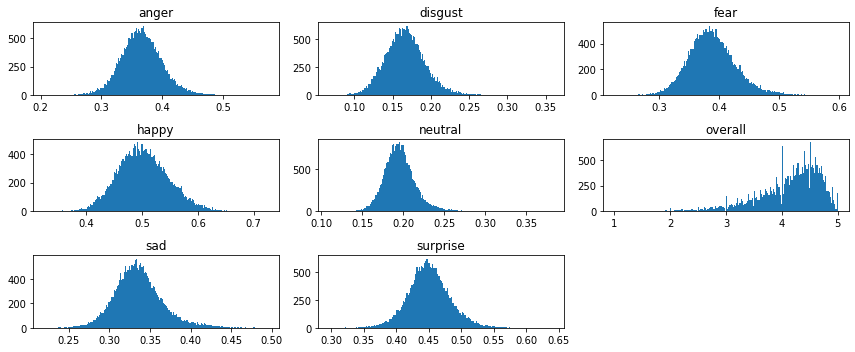

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

avg_movies_emotions.hist(figsize=(12, 5), bins=200,grid=False)
plt.tight_layout()

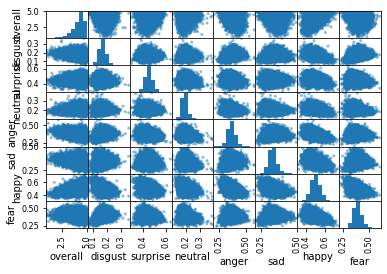

In [20]:
pd.plotting.scatter_matrix(avg_movies_emotions);

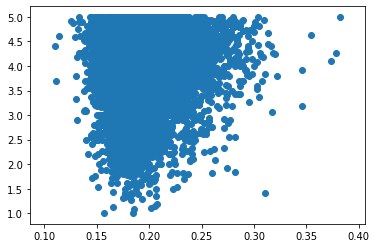

In [21]:
plt.scatter(avg_movies_emotions.neutral, avg_movies_emotions.overall)

# Study of movies with top 5% Fear review content

### Sort by scariness
Because the scare emotion would not be used to describe a movie's quality, but solely to describe the movie content

In [22]:
avg_movies_emotions.sort_values('fear', inplace = True) 
#nlargest(n=5, keep='all')

In [23]:
avg_movies_emotions.head()

,overall,disgust,surprise,neutral,anger,sad,happy,fear
asin,,,,,,,,
B000B9RKLW,4.700000,0.067192,0.464606,0.177617,0.306027,0.294992,0.594628,0.225453
B0000E2FLJ,4.769231,0.121772,0.392305,0.223979,0.226384,0.238471,0.679393,0.240365
B00069A5D2,4.800000,0.099415,0.460379,0.213141,0.309299,0.283440,0.550906,0.241056
B000BC8STM,4.250000,0.103803,0.400595,0.274620,0.267054,0.266966,0.568361,0.243715
B00092ZM0W,4.866667,0.119042,0.513048,0.268340,0.232713,0.249055,0.573325,0.248684


### Separate the top 5% scariest movies

In [24]:
scary_movies = avg_movies_emotions.iloc[-round(len(avg_movies_emotions.index) * 0.05):]

In [32]:
not_scary_movies = avg_movies_emotions.iloc[:round(len(avg_movies_emotions.index) * 0.95)]

In [33]:
len(scary_movies.index)

1244

In [34]:
not_scary_movies.head(1)

,overall,disgust,surprise,neutral,anger,sad,happy,fear
asin,,,,,,,,
B000B9RKLW,4.7,0.067192,0.464606,0.177617,0.306027,0.294992,0.594628,0.225453


#### Validation: most scary movies

In [35]:
# Option for validating movie titles
file_name = 'meta_Movies_and_TV.json.gz'
titles_df = getDF(data_path + file_name, add_emotions=False)

In [36]:
for asin in scary_movies.iloc[-5:].index:
    print(asin)
    print(titles_df[titles_df['asin'] == asin]['title'])

B0000633TH
47776    Freeze Me
Name: title, dtype: object
0780630904
1793    Wes Craven's New Nightmare
Name: title, dtype: object
0780619412
1592    Nightmare on Elm Street [VHS]
Name: title, dtype: object
B000AMFLCK
84115    Cancer Doesn't Scare Me Anymore!
Name: title, dtype: object
B00005AUK4
41988    The Pit and the Pendulum (Midnite Movies)
Name: title, dtype: object


In [37]:
len(not_scary_movies.index)

23632

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_hists_combined(df, df1, df2, name1, name2):
    '''
    Displays information of 2 sub groups of a data set 
    '''

    fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 30))
    for col_name, ax in zip(df1.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 40)
        height, binz = np.histogram(df1[col_name], bins=bins, density=True)
        bp1 = ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.5, color='g')
        height, binz = np.histogram(df2[col_name], bins=bins, density=True)
        bp2 = ax.bar(bins[:-1]+.5*(bins[1]-bins[0]), height,
                     .5*(bins[1]-bins[0]), color='b', alpha=.5)
        ax.set_title(col_name)
        ax.legend((bp1[0], bp2[0]), (name1, name2), loc='best')
    
    fig.subplots_adjust(hspace=.5)

#     plt.tight_layout()

    return fig, ax

(<Figure size 720x2160 with 8 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13779be80>)

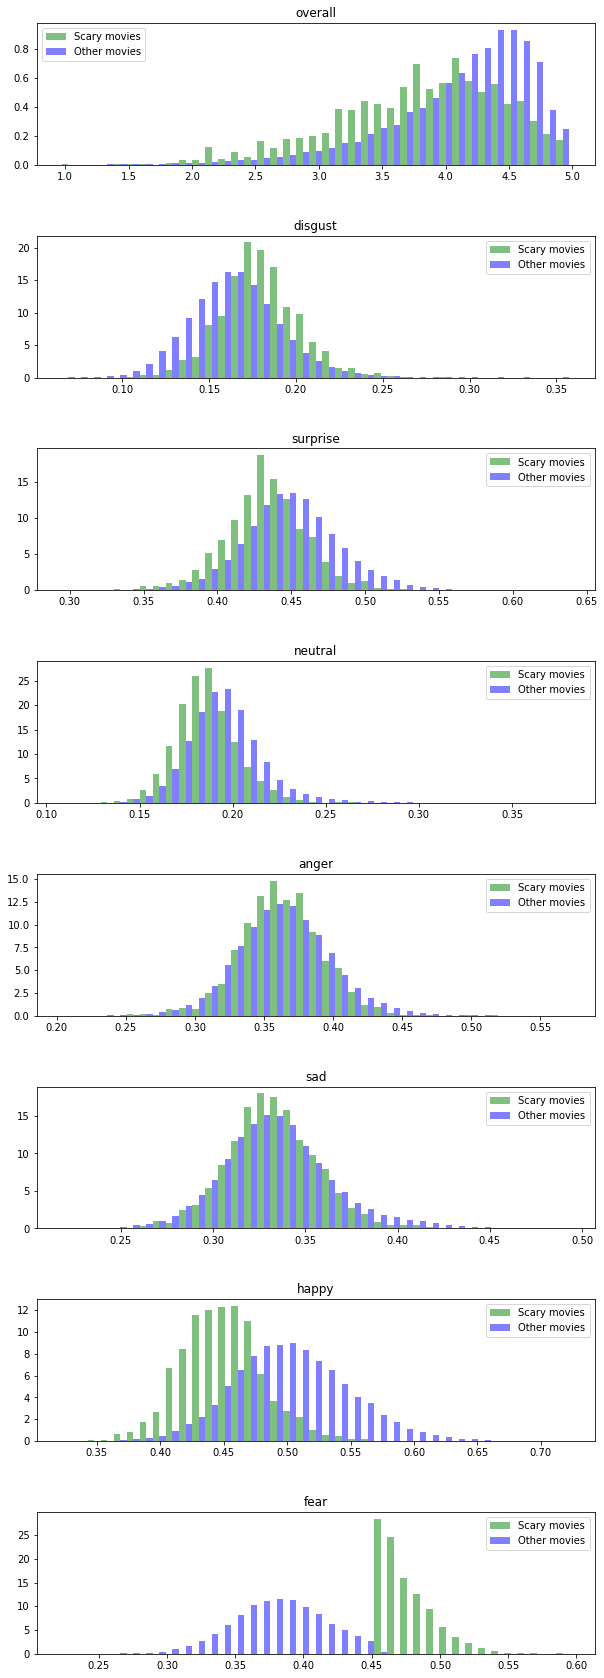

In [38]:
plot_hists_combined(avg_movies_emotions, scary_movies, not_scary_movies, 'Scary movies', 'Other movies')

### Graphs interpretation

The most scary movies rank higher on all emotional dimensions than movies as a whole

## Welch's T-Test: have scary movies the same average rating as other movies?

#### Strict test: α = 1%

In [39]:
from scipy import stats
stat, p_val = stats.ttest_ind(scary_movies.overall, not_scary_movies.overall, equal_var=False)

print('The statistic is: {0} \nP-value: {1}'.format(stat ,p_val))

The statistic is: -17.14813184706451 
P-value: 9.293110403984733e-60


p-value << α so scary movies do not have the same average rating as other movies

## U-Test

In [46]:
res = stats.mannwhitneyu(scary_movies.fear, not_scary_movies.fear, alternative="greater")
print("p-value for Scary movies rating > Average rating: {}".format(res.pvalue))

p-value for Scary movies rating > Average rating: 0.0


Scary movies rating is definitely less than average movie rating

In [41]:
scary_movies.shape

(1244, 8)

In [42]:
not_scary_movies.shape

(23632, 8)

# Happy Movies

In [43]:
movies_sort_happy = avg_movies_emotions.sort_values('happy', inplace = False) 

happy_movies = movies_sort_happy.iloc[-round(len(movies_sort_happy.index) * 0.05):]

In [44]:
not_happy_movies = movies_sort_happy.iloc[:round(len(movies_sort_happy.index) * 0.95)]


(<Figure size 720x2160 with 8 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1187719b0>)

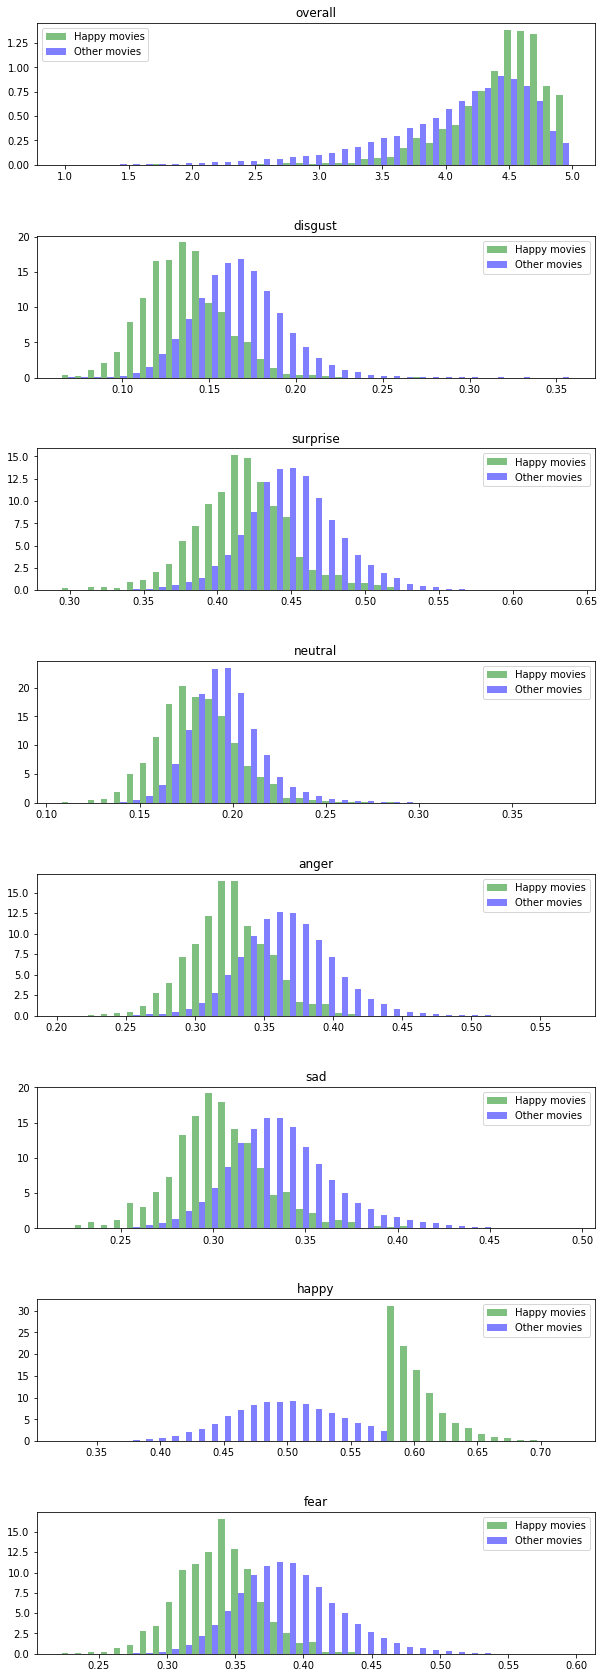

In [45]:
plot_hists_combined(avg_movies_emotions, happy_movies, not_happy_movies, 'Happy movies', 'Other movies')